In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [2]:
df_old = pd.read_stata(fpath + "/full_data_truncated.dta")
pvcc_ind = pd.read_stata(fpath + "/pvcc_ind.dta")
df = df_old.merge(pvcc_ind, how='inner', on=['vccsid']).drop(['pvcc'],axis=1)

In [43]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(7132, 341) (837, 341)


In [5]:
predictors = list(df.columns)[10:]
print(len(predictors))
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

331


In [6]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test                    

In [7]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [17]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [3]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test2\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [20]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.85124
Will train until validation-auc hasn't improved in 10 rounds.
Stopping. Best iteration:
[27]	validation-auc:0.880409


max_depth = 4, eta = 0.02:
[0]	validation-auc:0.85124
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.889622
[100]	validation-auc:0.895279
[150]	validation-auc:0.901226
[200]	validation-auc:0.90546
[250]	validation-auc:0.908336
[300]	validation-auc:0.910483
Stopping. Best iteration:
[312]	validation-auc:0.910936


max_depth = 4, eta = 0.05:
[0]	validation-auc:0.85124
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.899802
[100]	validation-auc:0.908633
[150]	validation-auc:0.913678
Stopping. Best iteration:
[158]	validation-auc:0.914115


max_depth = 4, eta = 0.1:
[0]	validation-auc:0.85124
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.907035
Stopping. Best iteration:
[80]	validation-auc:0.911996


max_depth =

In [21]:
for t in validation_auc_1.most_common():
    print(t)

((5, 0.05), 0.916889)
((6, 0.1), 0.916798)
((6, 0.05), 0.916313)
((5, 0.1), 0.915311)
((7, 0.05), 0.915021)
((4, 0.05), 0.914115)
((7, 0.02), 0.913217)
((4, 0.1), 0.911996)
((4, 0.2), 0.911253)
((7, 0.1), 0.911231)
((4, 0.02), 0.910936)
((5, 0.2), 0.909839)
((6, 0.2), 0.90964)
((7, 0.2), 0.907682)
((6, 0.02), 0.899548)
((5, 0.02), 0.897174)
((7, 0.01), 0.896469)
((6, 0.01), 0.892597)
((5, 0.01), 0.887648)
((4, 0.01), 0.880409)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [22]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.05, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.852388
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.904146
[100]	validation-auc:0.912145
Stopping. Best iteration:
[128]	validation-auc:0.914446


max_depth = 5, min_child_weight = 5:
[0]	validation-auc:0.855857
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.903265
[100]	validation-auc:0.910611
[150]	validation-auc:0.912852
[200]	validation-auc:0.913961
Stopping. Best iteration:
[190]	validation-auc:0.91419


max_depth = 6, min_child_weight = 3:
[0]	validation-auc:0.861215
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.905619
[100]	validation-auc:0.911909
Stopping. Best iteration:
[126]	validation-auc:0.913985


max_depth = 6, min_child_weight = 5:
[0]	validation-auc:0.862101
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.907132
[100]	validation-auc:0.913118
Stopping. Best iteratio

In [23]:
for t in validation_auc_2.most_common():
    print(t)

((7, 5), 0.915033)
((5, 3), 0.914446)
((5, 5), 0.91419)
((6, 3), 0.913985)
((7, 3), 0.913977)
((6, 5), 0.913272)


#### (3) Grid Search for colsample_by_tree

In [24]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.847992
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.908651
[100]	validation-auc:0.912638
[150]	validation-auc:0.915155
Stopping. Best iteration:
[144]	validation-auc:0.915199


colsample_by_tree = 0.55:
[0]	validation-auc:0.849902
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.907108
[100]	validation-auc:0.912835
Stopping. Best iteration:
[127]	validation-auc:0.913993


colsample_by_tree = 0.6:
[0]	validation-auc:0.85596
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.909614
[100]	validation-auc:0.914856
Stopping. Best iteration:
[106]	validation-auc:0.915411


colsample_by_tree = 0.65:
[0]	validation-auc:0.853712
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.908058
[100]	validation-auc:0.912003
[150]	validation-auc:0.915061
Stopping. Best iteration:
[158]	validation-auc:0.91534


colsample_by

In [25]:
validation_auc_3.most_common()

[(0.7, 0.917247),
 (0.9, 0.9172),
 (0.6, 0.915411),
 (0.65, 0.91534),
 (0.5, 0.915199),
 (0.8, 0.915033),
 (0.55, 0.913993),
 (0.75, 0.913741),
 (0.85, 0.91313)]

#### (4) Finally select the opitmal num_boost_round

In [26]:
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.853387
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.907938
[100]	validation-auc:0.913028
[150]	validation-auc:0.915825
Stopping. Best iteration:
[174]	validation-auc:0.917247


174


#### (5) Train the final xgb model and make predictions for observations in the test set

In [27]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [28]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9112


In [29]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "y_test_pred_xgb.p", "wb"))

In [30]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

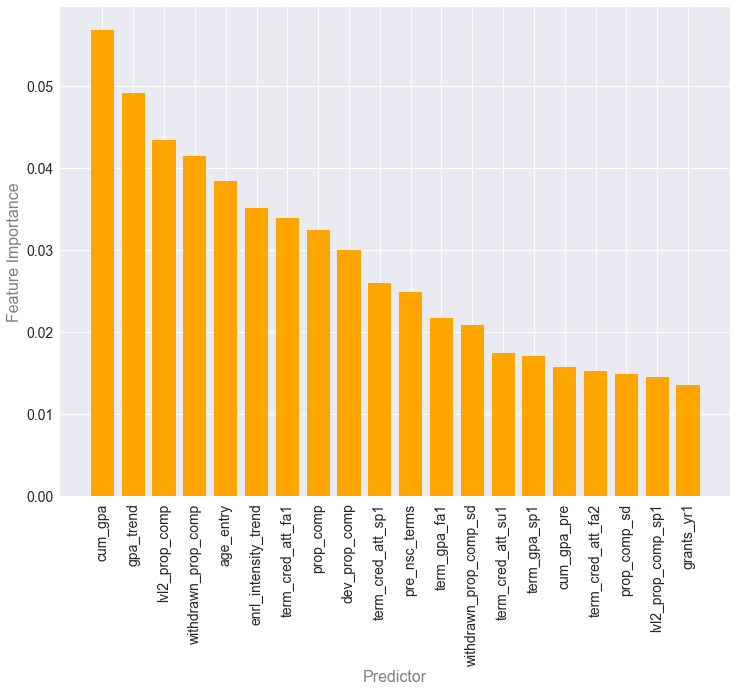

In [32]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [33]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [34]:
final_params = {'max_depth': 7, 'eta': 0.05, 'min_child_weight': 5, 'colsample_bytree': 0.7, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.9061777197349606 0.01854220160243723


In [35]:
best_threshold

0.39671963

In [36]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [37]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(y_test_pred, best_threshold, "XGBoost_cm1")

F1 threshold = 0.397:

        Pred_0  Pred_1       
Real_0   468.0    70.0  538.0
Real_1    71.0   228.0  299.0
         539.0   298.0  837.0

F1 score = 0.7638


In [38]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "XGBoost_cm2")

Alternative threshold = 0.438:

        Pred_0  Pred_1       
Real_0   480.0    58.0  538.0
Real_1    76.0   223.0  299.0
         556.0   281.0  837.0

F1 score = 0.769


In [39]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "XGBoost_precision_recall.csv", index=True)

#### Compare with the base model (trained on the full training sample)

In [48]:
results_dir_new = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test2\\comparison\\"

In [49]:
model_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_predictors\\"
base_xgboost = pickle.load(open(model_dir + "xgb.p", "rb"))

In [50]:
df_new = df_old.merge(pvcc_ind, how='inner', on=['vccsid']).drop(['pvcc'],axis=1)
test_df = df_new[df_new.valid == 1]
train_df_old = df_old[df_old.valid == 0]

In [51]:
_, test_df_new = impute(train_df_old, test_df)
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years
dtest = xgb.DMatrix(X_test, y_test)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [52]:
print("XGBoost:")
y_test_pred = base_xgboost.predict(dtest)
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), base_xgboost.predict(dtest)), 4)))

XGBoost:
AUC = 0.9254


In [53]:
def create_confusion_matrix_new(y_test, y_test_pred, threshold, fpath, fname):
    cm_arr = confusion_matrix(y_test, np.where(np.array(y_test_pred) > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(fpath + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [54]:
def create_pr(train_df, y_test, y_test_pred, best_threshold, fpath, mn):
    print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
    pr_lr = create_confusion_matrix_new(y_test, y_test_pred, best_threshold, fpath, "{}_cm1".format(mn))

    num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
    y_test_pred_binary = np.ones(len(y_test))
    y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
    alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
    print("\n\n")
    print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
    pr2_lr = create_confusion_matrix_new(y_test, y_test_pred_binary, best_threshold, fpath, "{}_cm2".format(mn))

    precision_recall_df = pd.DataFrame([(best_threshold,)+pr_lr,(alternative_threshold,)+pr2_lr]).round(4)
    precision_recall_df.index = ['F1','Same_Graduation_Rate']
    precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
    precision_recall_df.to_csv(fpath + "{}_precision_recall.csv".format(mn), index=True)

In [55]:
create_pr(train_df, y_test, y_test_pred, 0.38526425, results_dir_new, "XGBoost")

F1 threshold = 0.385:

        Pred_0  Pred_1       
Real_0   479.0    59.0  538.0
Real_1    56.0   243.0  299.0
         535.0   302.0  837.0

F1 score = 0.8087



Alternative threshold = 0.44:

        Pred_0  Pred_1       
Real_0   488.0    50.0  538.0
Real_1    68.0   231.0  299.0
         556.0   281.0  837.0

F1 score = 0.7966


#### Reorganize files of key evaluation metrics for the five models fitted on the PVCC-only training sample: OLS, Logit, RF, XGBoost, CoxPH

In [4]:
results_dir_new = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test2\\comparison\\"

In [5]:
# Key evaluation metrics used to generate Appendix Figure A23 of the paper
cstat = [0.9015, 0.8978, 0.8978, 0.9112] + [0.9127, 0.9083, 0.912, 0.9254]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost'}
m_list = ['Logit', 'OLS', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat[:4],m_list):
    summary.append((m,"pvcc","pvcc",c)+tuple(pd.read_csv(results_dir + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
for c,m in zip(cstat[4:],m_list):
    summary.append((m,"full","pvcc",c)+tuple(pd.read_csv(results_dir_new + "\\{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model', 'training_sample', 'validation_sample',
                                            'c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = 2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)
summary_df.round(4).to_csv(results_dir + "cleaned_results\\main_eval_metrics.csv", index=False)

In [1]:
import os
os.chdir("C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\smaller_training_sample\\test2")

In [2]:
# save the predicted scores of all PVCC-only models into a single table, for easier retrieval in subsequent steps
pred_score_dict = {}
for k,v in m2_dict.items():
    pred_score_dict[v] = pickle.load(open(results_dir+"/y_test_pred_{}.p".format(k), "rb"))
pd.DataFrame(pred_score_dict, index=list(test_df.vccsid)).sort_index().to_csv(results_dir+"cleaned_results/all_pred_scores.csv")